In [1]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce
import datetime


In [2]:
L = 5 #system size
l=1 #spin length
M = -0.35
m_epsilon = 0
N=2
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [3]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
       0.         |2 2 2 2 2>           242  
       1.         |2 2 2 2 1>           241  
       2.         |2 2 2 2 0>           240  
       3.         |2 2 2 1 2>           239  
       4.         |2 2 2 1 1>           238  
       5.         |2 2 2 1 0>           237  
       6.         |2 2 2 0 2>           236  
       7.         |2 2 2 0 1>           235  
       8.         |2 2 2 0 0>           234  
       9.         |2 2 1 2 2>           233  
      10.         |2 2 1 2 1>           232  
      11.         |2 2 1 2 0>           231  
      12.         |2 2 1 1 2>           230  
      13.         |2 2 1 1 1>           229  
      14.         |2 2 1 1 0>           228  
      15.         |2 2 1 0 2>           227  
      16.         |2 2 1 0 1>           226  
      17.         |2 2 1 0 0>           225  
      18.         |2 2 0 2 2>           224  
      19.         |2 2 0 2 1>           223  
      20.  

In [4]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [5]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [6]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [7]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [8]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [9]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [10]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [11]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [12]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [13]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-2.00142096 -1.46230785 -1.1410947 ]


In [14]:
#s_xy = [[1.,i,i+1] for i in range(L-1)]
#s_z = [[0.47,i] for i in range(L)]

#ham_map = [
    
#    ["xx",s_xy],
#    ["yy",s_xy],
#    ["z",s_z],


#]

#XYZ = hamiltonian(ham_map,dynamic_list=[],basis=basis,**no_checks)


In [15]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [16]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [17]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [18]:
def R(i,theta):
    
    if i%11 == 0:
        return(ms_gate_global(theta))

    if i%11 == 1:
        return(ms_gate_global_1(theta))

    if i%11 == 2:
        return(rot_sigma_e(0,1,0,theta).toarray())


    if i%11 == 3:
        return(rot_sigma_e(0,2,0,theta).toarray())

    
    if i%11 == 4:
        return(rot_sigma_e(1,2,np.pi/2,theta).toarray())
    
    
    if i%11 == 5:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%11 == 6:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%11 == 7:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%11 == 8:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%11 == 9:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%11 == 10:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
    
def S(i):
    
    if i%11 == 0:
        return(-1j*matrix_part)
    
    if i%11 == 1:
        return(-1j*matrix_part_1)

    if i%11 == 2:
        return(-1j*sigma_e(0,1,0).toarray())

    
    if i%11 == 3:
        return(-1j*sigma_e(0,2,0).toarray())

    
    if i%11 == 4:
        return(-1j*sigma_e(1,2,np.pi/2).toarray())


     
    if i%11 == 5:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%11 == 6:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%11 == 7:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%11 == 8:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%11 == 9:
        return(-1j*sigma_r(0,2,0).toarray())

    
    if i%11 == 10:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())


In [19]:
coeff = 11

In [20]:
matr = full_ham_matrix.toarray()
ones = np.ones(coeff*N)
ID = np.identity(coeff*N)
psi_0_conj = np.conj(psi_0)
A = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
dd = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]

In [21]:
def rhs(t,theta):
    #A = [-1j*entanglement_ham.toarray()@exp_ent(theta[0]),-1j*sigma_z.toarray()@exp_sigma_z(theta[1]),-1j*sigma_x.toarray()@exp_sigma_x(theta[2]),-1j*sigma_z.toarray()@exp_sigma_z(theta[3])]
    #B = [exp_ent(theta[0]),exp_sigma_z(theta[1]),exp_sigma_x(theta[2]),exp_sigma_z(theta[3])]
    ID = np.identity(coeff*N)

    print(datetime.datetime.now())
    for k in range(coeff*N):
        A[k] = S(k)@R(k,theta[k])
        B[k] = R(k,theta[k])

    CC = np.einsum("i,ljk->iljk",np.ones(coeff*N),B)

    AA = np.einsum("ijk,il->iljk",A,ID)

    BB = np.einsum("ijk,il->iljk",B,ID)

    DD = CC-BB+AA

    for i in range(coeff*N):
        dd[i] = reduce(np.dot,DD[i])
    DD = np.array(dd)

    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)

    BBB = reduce(np.dot,B)
    DD_d = np.einsum("kij->kji",DD.conj())
    BBB_dagger = BBB.conj().T

    
    
    psi_conj_d = np.einsum("m,imn->in",psi_0_conj,DD_d)
    psi_d = np.einsum("jnl,l->jn",DD,psi_0)
    
    psi_conj_b = np.einsum("m,mn->n",psi_0_conj,BBB_dagger)
    psi_b = np.einsum("lk,k->l",BBB,psi_0)

    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [22]:
stepp = 1000

In [23]:
time_domain = np.linspace(0, 10, stepp)
Y = []

In [24]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [25]:
start_point = 0.001*np.ones(coeff*N)
#for i in range(4*N):
#    start_point[i] += i/4*N
rk4(0,0.001*np.ones(coeff*N),10,stepp)


2022-07-22 10:14:54.009515
2022-07-22 10:14:55.185716
0
2022-07-22 10:14:55.188695
2022-07-22 10:14:56.328279
0.005
2022-07-22 10:14:56.330881
2022-07-22 10:14:57.470238
0.005
2022-07-22 10:14:57.472695
2022-07-22 10:14:58.670526
0.01
2022-07-22 10:14:58.673505
2022-07-22 10:14:59.854639
0.01
2022-07-22 10:14:59.857152
2022-07-22 10:15:00.996958
0.015
2022-07-22 10:15:00.999426
2022-07-22 10:15:02.140348
0.015
2022-07-22 10:15:02.142827
2022-07-22 10:15:03.290136
0.02
2022-07-22 10:15:03.292659
2022-07-22 10:15:04.436844
0.02
2022-07-22 10:15:04.439275
2022-07-22 10:15:05.587311
0.025
2022-07-22 10:15:05.589926
2022-07-22 10:15:06.735372
0.025
2022-07-22 10:15:06.737951
2022-07-22 10:15:07.885135
0.03
2022-07-22 10:15:07.887602
2022-07-22 10:15:09.032769
0.03
2022-07-22 10:15:09.035367
2022-07-22 10:15:10.185838
0.034999999999999996
2022-07-22 10:15:10.188394
2022-07-22 10:15:11.437177
0.034999999999999996
2022-07-22 10:15:11.440225
2022-07-22 10:15:12.618622
0.04
2022-07-22 10:15:12.6

2022-07-22 10:17:13.854334
0.3000000000000001
2022-07-22 10:17:13.856893
2022-07-22 10:17:14.994716
0.3050000000000001
2022-07-22 10:17:14.997294
2022-07-22 10:17:16.134889
0.3050000000000001
2022-07-22 10:17:16.137438
2022-07-22 10:17:17.275743
0.3100000000000001
2022-07-22 10:17:17.278439
2022-07-22 10:17:18.428563
0.3100000000000001
2022-07-22 10:17:18.431180
2022-07-22 10:17:19.580557
0.3150000000000001
2022-07-22 10:17:19.583244
2022-07-22 10:17:20.733097
0.3150000000000001
2022-07-22 10:17:20.735733
2022-07-22 10:17:21.879970
0.3200000000000001
2022-07-22 10:17:21.882717
2022-07-22 10:17:23.026868
0.3200000000000001
2022-07-22 10:17:23.029613
2022-07-22 10:17:24.170433
0.3250000000000001
2022-07-22 10:17:24.173102
2022-07-22 10:17:25.315704
0.3250000000000001
2022-07-22 10:17:25.318282
2022-07-22 10:17:26.463559
0.3300000000000001
2022-07-22 10:17:26.466243
2022-07-22 10:17:27.619585
0.3300000000000001
2022-07-22 10:17:27.622155
2022-07-22 10:17:28.769620
0.33500000000000013
2022

2022-07-22 10:19:22.284553
0.5800000000000003
2022-07-22 10:19:22.287212
2022-07-22 10:19:23.436473
0.5850000000000003
2022-07-22 10:19:23.439016
2022-07-22 10:19:24.577457
0.5850000000000003
2022-07-22 10:19:24.580141
2022-07-22 10:19:25.719049
0.5900000000000003
2022-07-22 10:19:25.721783
2022-07-22 10:19:26.858353
0.5900000000000003
2022-07-22 10:19:26.860851
2022-07-22 10:19:28.000967
0.5950000000000003
2022-07-22 10:19:28.003671
2022-07-22 10:19:29.147461
0.5950000000000003
2022-07-22 10:19:29.150059
2022-07-22 10:19:30.289823
0.6000000000000003
2022-07-22 10:19:30.292495
2022-07-22 10:19:31.431812
0.6000000000000003
2022-07-22 10:19:31.434358
2022-07-22 10:19:32.577531
0.6050000000000003
2022-07-22 10:19:32.580026
2022-07-22 10:19:33.734030
0.6050000000000003
2022-07-22 10:19:33.736692
2022-07-22 10:19:34.880710
0.6100000000000003
2022-07-22 10:19:34.883721
2022-07-22 10:19:36.028174
0.6100000000000003
2022-07-22 10:19:36.030782
2022-07-22 10:19:37.172934
0.6150000000000003
2022-

2022-07-22 10:21:32.073382
0.8650000000000005
2022-07-22 10:21:32.076048
2022-07-22 10:21:33.220309
0.8650000000000005
2022-07-22 10:21:33.223102
2022-07-22 10:21:34.369421
0.8700000000000006
2022-07-22 10:21:34.372046
2022-07-22 10:21:35.517450
0.8700000000000006
2022-07-22 10:21:35.520041
2022-07-22 10:21:36.664830
0.8750000000000006
2022-07-22 10:21:36.667377
2022-07-22 10:21:37.816266
0.8750000000000006
2022-07-22 10:21:37.818897
2022-07-22 10:21:38.973643
0.8800000000000006
2022-07-22 10:21:38.976888
2022-07-22 10:21:40.184139
0.8800000000000006
2022-07-22 10:21:40.186639
2022-07-22 10:21:41.346726
0.8850000000000006
2022-07-22 10:21:41.349372
2022-07-22 10:21:42.494535
0.8850000000000006
2022-07-22 10:21:42.497145
2022-07-22 10:21:43.642014
0.8900000000000006
2022-07-22 10:21:43.644629
2022-07-22 10:21:44.789169
0.8900000000000006
2022-07-22 10:21:44.791756
2022-07-22 10:21:45.937077
0.8950000000000006
2022-07-22 10:21:45.939751
2022-07-22 10:21:47.087978
0.8950000000000006
2022-

2022-07-22 10:23:42.932405
1.1450000000000007
2022-07-22 10:23:42.935143
2022-07-22 10:23:44.083235
1.1500000000000008
2022-07-22 10:23:44.085842
2022-07-22 10:23:45.233364
1.1500000000000008
2022-07-22 10:23:45.235829
2022-07-22 10:23:46.395031
1.1550000000000007
2022-07-22 10:23:46.397669
2022-07-22 10:23:47.547605
1.1550000000000007
2022-07-22 10:23:47.550163
2022-07-22 10:23:48.703659
1.1600000000000008
2022-07-22 10:23:48.706332
2022-07-22 10:23:49.860394
1.1600000000000008
2022-07-22 10:23:49.863118
2022-07-22 10:23:51.016908
1.1650000000000007
2022-07-22 10:23:51.019635
2022-07-22 10:23:52.167171
1.1650000000000007
2022-07-22 10:23:52.169912
2022-07-22 10:23:53.316865
1.1700000000000008
2022-07-22 10:23:53.319396
2022-07-22 10:23:54.466816
1.1700000000000008
2022-07-22 10:23:54.469489
2022-07-22 10:23:55.612700
1.1750000000000007
2022-07-22 10:23:55.615182
2022-07-22 10:23:56.765623
1.1750000000000007
2022-07-22 10:23:56.768505
2022-07-22 10:23:57.922933
1.1800000000000008
2022-

2022-07-22 10:25:59.645553
1.430000000000001
2022-07-22 10:25:59.648489
2022-07-22 10:26:00.872758
1.430000000000001
2022-07-22 10:26:00.875624
2022-07-22 10:26:02.101119
1.435000000000001
2022-07-22 10:26:02.104093
2022-07-22 10:26:03.335091
1.435000000000001
2022-07-22 10:26:03.338127
2022-07-22 10:26:04.569521
1.440000000000001
2022-07-22 10:26:04.572473
2022-07-22 10:26:05.794896
1.440000000000001
2022-07-22 10:26:05.797789
2022-07-22 10:26:07.025187
1.445000000000001
2022-07-22 10:26:07.028208
2022-07-22 10:26:08.250931
1.445000000000001
2022-07-22 10:26:08.253888
2022-07-22 10:26:09.478271
1.450000000000001
2022-07-22 10:26:09.481052
2022-07-22 10:26:10.710420
1.450000000000001
2022-07-22 10:26:10.713495
2022-07-22 10:26:11.945661
1.455000000000001
2022-07-22 10:26:11.948632
2022-07-22 10:26:13.169264
1.455000000000001
2022-07-22 10:26:13.172219
2022-07-22 10:26:14.397518
1.460000000000001
2022-07-22 10:26:14.400416
2022-07-22 10:26:15.619854
1.460000000000001
2022-07-22 10:26:15

2022-07-22 10:28:18.288021
1.7100000000000013
2022-07-22 10:28:18.291356
2022-07-22 10:28:19.506377
1.7150000000000012
2022-07-22 10:28:19.509343
2022-07-22 10:28:20.727105
1.7150000000000012
2022-07-22 10:28:20.730054
2022-07-22 10:28:21.947891
1.7200000000000013
2022-07-22 10:28:21.950787
2022-07-22 10:28:23.170144
1.7200000000000013
2022-07-22 10:28:23.173029
2022-07-22 10:28:24.398583
1.7250000000000012
2022-07-22 10:28:24.401600
2022-07-22 10:28:25.623607
1.7250000000000012
2022-07-22 10:28:25.626619
2022-07-22 10:28:26.835857
1.7300000000000013
2022-07-22 10:28:26.838862
2022-07-22 10:28:28.054747
1.7300000000000013
2022-07-22 10:28:28.057642
2022-07-22 10:28:29.280029
1.7350000000000012
2022-07-22 10:28:29.283256
2022-07-22 10:28:30.499248
1.7350000000000012
2022-07-22 10:28:30.502267
2022-07-22 10:28:31.714197
1.7400000000000013
2022-07-22 10:28:31.717292
2022-07-22 10:28:32.933411
1.7400000000000013
2022-07-22 10:28:32.936358
2022-07-22 10:28:34.145746
1.7450000000000012
2022-

2022-07-22 10:30:36.355596
1.9950000000000014
2022-07-22 10:30:36.358622
2022-07-22 10:30:37.575241
1.9950000000000014
2022-07-22 10:30:37.578054
2022-07-22 10:30:38.789243
2.0000000000000013
2022-07-22 10:30:38.792014
2022-07-22 10:30:40.013497
2.0000000000000013
2022-07-22 10:30:40.016526
2022-07-22 10:30:41.251268
2.0050000000000012
2022-07-22 10:30:41.254027
2022-07-22 10:30:42.470697
2.0050000000000012
2022-07-22 10:30:42.473801
2022-07-22 10:30:43.690098
2.010000000000001
2022-07-22 10:30:43.692814
2022-07-22 10:30:44.909850
2.010000000000001
2022-07-22 10:30:44.912630
2022-07-22 10:30:46.135285
2.015000000000001
2022-07-22 10:30:46.138254
2022-07-22 10:30:47.362392
2.015000000000001
2022-07-22 10:30:47.365097
2022-07-22 10:30:48.583422
2.020000000000001
2022-07-22 10:30:48.586388
2022-07-22 10:30:49.800901
2.020000000000001
2022-07-22 10:30:49.803750
2022-07-22 10:30:51.024252
2.025000000000001
2022-07-22 10:30:51.027176
2022-07-22 10:30:52.243436
2.025000000000001
2022-07-22 10

2022-07-22 10:33:06.567797
2.2799999999999954
2022-07-22 10:33:06.570882
2022-07-22 10:33:07.980826
2.2849999999999953
2022-07-22 10:33:07.984050
2022-07-22 10:33:09.402913
2.2849999999999953
2022-07-22 10:33:09.406314
2022-07-22 10:33:10.820831
2.289999999999995
2022-07-22 10:33:10.824573
2022-07-22 10:33:12.251267
2.289999999999995
2022-07-22 10:33:12.254655
2022-07-22 10:33:13.636239
2.294999999999995
2022-07-22 10:33:13.639418
2022-07-22 10:33:14.961046
2.294999999999995
2022-07-22 10:33:14.964284
2022-07-22 10:33:16.280421
2.299999999999995
2022-07-22 10:33:16.283653
2022-07-22 10:33:17.596229
2.299999999999995
2022-07-22 10:33:17.599529
2022-07-22 10:33:18.912594
2.304999999999995
2022-07-22 10:33:18.915873
2022-07-22 10:33:20.264351
2.304999999999995
2022-07-22 10:33:20.267783
2022-07-22 10:33:21.732122
2.3099999999999947
2022-07-22 10:33:21.735497
2022-07-22 10:33:23.154152
2.3099999999999947
2022-07-22 10:33:23.157584
2022-07-22 10:33:24.540770
2.3149999999999946
2022-07-22 10

2022-07-22 10:35:36.708702
2.5649999999999893
2022-07-22 10:35:36.711541
2022-07-22 10:35:37.914583
2.569999999999989
2022-07-22 10:35:37.917340
2022-07-22 10:35:39.113139
2.569999999999989
2022-07-22 10:35:39.116560
2022-07-22 10:35:40.327607
2.574999999999989
2022-07-22 10:35:40.330679
2022-07-22 10:35:41.591050
2.574999999999989
2022-07-22 10:35:41.593969
2022-07-22 10:35:42.813789
2.579999999999989
2022-07-22 10:35:42.816600
2022-07-22 10:35:44.029524
2.579999999999989
2022-07-22 10:35:44.032600
2022-07-22 10:35:45.322278
2.584999999999989
2022-07-22 10:35:45.325442
2022-07-22 10:35:46.627789
2.584999999999989
2022-07-22 10:35:46.631036
2022-07-22 10:35:47.936868
2.5899999999999888
2022-07-22 10:35:47.940362
2022-07-22 10:35:49.244358
2.5899999999999888
2022-07-22 10:35:49.247891
2022-07-22 10:35:50.508937
2.5949999999999886
2022-07-22 10:35:50.511817
2022-07-22 10:35:51.715281
2.5949999999999886
2022-07-22 10:35:51.718031
2022-07-22 10:35:52.938834
2.5999999999999885
2022-07-22 10

2022-07-22 10:37:59.498449
2.849999999999983
2022-07-22 10:37:59.501343
2022-07-22 10:38:00.764943
2.849999999999983
2022-07-22 10:38:00.768173
2022-07-22 10:38:02.075676
2.854999999999983
2022-07-22 10:38:02.078712
2022-07-22 10:38:03.380356
2.854999999999983
2022-07-22 10:38:03.383694
2022-07-22 10:38:04.678948
2.859999999999983
2022-07-22 10:38:04.682155
2022-07-22 10:38:05.988708
2.859999999999983
2022-07-22 10:38:05.991751
2022-07-22 10:38:07.303168
2.864999999999983
2022-07-22 10:38:07.306395
2022-07-22 10:38:08.600015
2.864999999999983
2022-07-22 10:38:08.603178
2022-07-22 10:38:09.901360
2.869999999999983
2022-07-22 10:38:09.904537
2022-07-22 10:38:11.214986
2.869999999999983
2022-07-22 10:38:11.218105
2022-07-22 10:38:12.509385
2.8749999999999827
2022-07-22 10:38:12.512723
2022-07-22 10:38:13.815561
2.8749999999999827
2022-07-22 10:38:13.818767
2022-07-22 10:38:15.168084
2.8799999999999826
2022-07-22 10:38:15.171254
2022-07-22 10:38:16.463594
2.8799999999999826
2022-07-22 10:3

2022-07-22 10:40:25.753383
3.134999999999977
2022-07-22 10:40:25.756353
2022-07-22 10:40:27.008606
3.134999999999977
2022-07-22 10:40:27.011409
2022-07-22 10:40:28.225653
3.139999999999977
2022-07-22 10:40:28.228399
2022-07-22 10:40:29.439217
3.139999999999977
2022-07-22 10:40:29.442089
2022-07-22 10:40:30.646334
3.144999999999977
2022-07-22 10:40:30.649221
2022-07-22 10:40:31.858360
3.144999999999977
2022-07-22 10:40:31.861187
2022-07-22 10:40:33.079820
3.149999999999977
2022-07-22 10:40:33.082634
2022-07-22 10:40:34.301990
3.149999999999977
2022-07-22 10:40:34.304815
2022-07-22 10:40:35.550997
3.1549999999999767
2022-07-22 10:40:35.554059
2022-07-22 10:40:36.880042
3.1549999999999767
2022-07-22 10:40:36.882982
2022-07-22 10:40:38.184791
3.1599999999999766
2022-07-22 10:40:38.188008
2022-07-22 10:40:39.488502
3.1599999999999766
2022-07-22 10:40:39.491616
2022-07-22 10:40:40.785787
3.1649999999999765
2022-07-22 10:40:40.788931
2022-07-22 10:40:42.097637
3.1649999999999765
2022-07-22 10

2022-07-22 10:42:51.259646
3.414999999999971
2022-07-22 10:42:51.262641
2022-07-22 10:42:52.557235
3.419999999999971
2022-07-22 10:42:52.560123
2022-07-22 10:42:53.849716
3.419999999999971
2022-07-22 10:42:53.853051
2022-07-22 10:42:55.139550
3.424999999999971
2022-07-22 10:42:55.142431
2022-07-22 10:42:56.434042
3.424999999999971
2022-07-22 10:42:56.436969
2022-07-22 10:42:57.735166
3.429999999999971
2022-07-22 10:42:57.738287
2022-07-22 10:42:59.029773
3.429999999999971
2022-07-22 10:42:59.033206
2022-07-22 10:43:00.331787
3.4349999999999707
2022-07-22 10:43:00.334885
2022-07-22 10:43:01.618702
3.4349999999999707
2022-07-22 10:43:01.621812
2022-07-22 10:43:02.915004
3.4399999999999706
2022-07-22 10:43:02.918110
2022-07-22 10:43:04.215739
3.4399999999999706
2022-07-22 10:43:04.219121
2022-07-22 10:43:05.516982
3.4449999999999705
2022-07-22 10:43:05.520065
2022-07-22 10:43:06.801686
3.4449999999999705
2022-07-22 10:43:06.804710
2022-07-22 10:43:08.105984
3.4499999999999704
2022-07-22 1

2022-07-22 10:45:30.849372
3.699999999999965
2022-07-22 10:45:30.852322
2022-07-22 10:45:32.149621
3.704999999999965
2022-07-22 10:45:32.152693
2022-07-22 10:45:33.453771
3.704999999999965
2022-07-22 10:45:33.456752
2022-07-22 10:45:34.764634
3.709999999999965
2022-07-22 10:45:34.767861
2022-07-22 10:45:36.079231
3.709999999999965
2022-07-22 10:45:36.082140
2022-07-22 10:45:37.382139
3.7149999999999648
2022-07-22 10:45:37.385170
2022-07-22 10:45:38.702205
3.7149999999999648
2022-07-22 10:45:38.705047
2022-07-22 10:45:40.046427
3.7199999999999647
2022-07-22 10:45:40.049599
2022-07-22 10:45:41.439644
3.7199999999999647
2022-07-22 10:45:41.442743
2022-07-22 10:45:42.757844
3.7249999999999646
2022-07-22 10:45:42.761094
2022-07-22 10:45:44.056133
3.7249999999999646
2022-07-22 10:45:44.058968
2022-07-22 10:45:45.364863
3.7299999999999645
2022-07-22 10:45:45.367711
2022-07-22 10:45:46.683733
3.7299999999999645
2022-07-22 10:45:46.686544
2022-07-22 10:45:47.990873
3.7349999999999643
2022-07-22

2022-07-22 10:47:59.998570
3.984999999999959
2022-07-22 10:48:00.001685
2022-07-22 10:48:01.316239
3.989999999999959
2022-07-22 10:48:01.319156
2022-07-22 10:48:02.622346
3.989999999999959
2022-07-22 10:48:02.625350
2022-07-22 10:48:03.918067
3.994999999999959
2022-07-22 10:48:03.921155
2022-07-22 10:48:05.221594
3.994999999999959
2022-07-22 10:48:05.224510
2022-07-22 10:48:06.525892
3.9999999999999587
2022-07-22 10:48:06.528630
2022-07-22 10:48:07.836927
3.9999999999999587
2022-07-22 10:48:07.839878
2022-07-22 10:48:09.143357
4.004999999999959
2022-07-22 10:48:09.146273
2022-07-22 10:48:10.460375
4.004999999999959
2022-07-22 10:48:10.463271
2022-07-22 10:48:11.753534
4.009999999999959
2022-07-22 10:48:11.756588
2022-07-22 10:48:13.065676
4.009999999999959
2022-07-22 10:48:13.068618
2022-07-22 10:48:14.376861
4.014999999999959
2022-07-22 10:48:14.379861
2022-07-22 10:48:15.671625
4.014999999999959
2022-07-22 10:48:15.674429
2022-07-22 10:48:16.993519
4.019999999999959
2022-07-22 10:48:

2022-07-22 10:50:28.815005
4.269999999999953
2022-07-22 10:50:28.817940
2022-07-22 10:50:30.121076
4.274999999999953
2022-07-22 10:50:30.124138
2022-07-22 10:50:31.426411
4.274999999999953
2022-07-22 10:50:31.429240
2022-07-22 10:50:32.737175
4.279999999999953
2022-07-22 10:50:32.740127
2022-07-22 10:50:34.056950
4.279999999999953
2022-07-22 10:50:34.059863
2022-07-22 10:50:35.371680
4.284999999999953
2022-07-22 10:50:35.374534
2022-07-22 10:50:36.628521
4.284999999999953
2022-07-22 10:50:36.631774
2022-07-22 10:50:37.887363
4.289999999999953
2022-07-22 10:50:37.890213
2022-07-22 10:50:39.144400
4.289999999999953
2022-07-22 10:50:39.147736
2022-07-22 10:50:40.402791
4.294999999999953
2022-07-22 10:50:40.405783
2022-07-22 10:50:41.657559
4.294999999999953
2022-07-22 10:50:41.660438
2022-07-22 10:50:42.915560
4.299999999999953
2022-07-22 10:50:42.918480
2022-07-22 10:50:44.170410
4.299999999999953
2022-07-22 10:50:44.173779
2022-07-22 10:50:45.436240
4.304999999999953
2022-07-22 10:50:45

2022-07-22 10:52:56.648901
4.554999999999947
2022-07-22 10:52:56.651929
2022-07-22 10:52:57.965979
4.559999999999947
2022-07-22 10:52:57.968983
2022-07-22 10:52:59.275177
4.559999999999947
2022-07-22 10:52:59.278174
2022-07-22 10:53:00.582828
4.564999999999947
2022-07-22 10:53:00.585777
2022-07-22 10:53:01.896044
4.564999999999947
2022-07-22 10:53:01.899114
2022-07-22 10:53:03.214935
4.569999999999947
2022-07-22 10:53:03.217885
2022-07-22 10:53:04.535996
4.569999999999947
2022-07-22 10:53:04.539058
2022-07-22 10:53:05.846129
4.574999999999947
2022-07-22 10:53:05.848962
2022-07-22 10:53:07.158853
4.574999999999947
2022-07-22 10:53:07.161839
2022-07-22 10:53:08.469802
4.579999999999947
2022-07-22 10:53:08.472651
2022-07-22 10:53:09.781824
4.579999999999947
2022-07-22 10:53:09.784716
2022-07-22 10:53:11.099761
4.584999999999947
2022-07-22 10:53:11.102665
2022-07-22 10:53:12.418495
4.584999999999947
2022-07-22 10:53:12.421436
2022-07-22 10:53:13.731402
4.589999999999947
2022-07-22 10:53:13

2022-07-22 10:55:29.110949
4.839999999999941
2022-07-22 10:55:29.114014
2022-07-22 10:55:30.520039
4.844999999999941
2022-07-22 10:55:30.523490
2022-07-22 10:55:31.967828
4.844999999999941
2022-07-22 10:55:31.970775
2022-07-22 10:55:33.389199
4.849999999999941
2022-07-22 10:55:33.392247
2022-07-22 10:55:34.800093
4.849999999999941
2022-07-22 10:55:34.803352
2022-07-22 10:55:36.189925
4.854999999999941
2022-07-22 10:55:36.192793
2022-07-22 10:55:37.530902
4.854999999999941
2022-07-22 10:55:37.533702
2022-07-22 10:55:38.845599
4.859999999999941
2022-07-22 10:55:38.848697
2022-07-22 10:55:40.288566
4.859999999999941
2022-07-22 10:55:40.292058
2022-07-22 10:55:41.675528
4.864999999999941
2022-07-22 10:55:41.678471
2022-07-22 10:55:43.014086
4.864999999999941
2022-07-22 10:55:43.017019
2022-07-22 10:55:44.356026
4.869999999999941
2022-07-22 10:55:44.358749
2022-07-22 10:55:45.687440
4.869999999999941
2022-07-22 10:55:45.690746
2022-07-22 10:55:47.035385
4.8749999999999405
2022-07-22 10:55:4

2022-07-22 10:58:04.645047
5.124999999999935
2022-07-22 10:58:04.648368
2022-07-22 10:58:06.045392
5.129999999999935
2022-07-22 10:58:06.048807
2022-07-22 10:58:07.436379
5.129999999999935
2022-07-22 10:58:07.439744
2022-07-22 10:58:08.829235
5.134999999999935
2022-07-22 10:58:08.832577
2022-07-22 10:58:10.225646
5.134999999999935
2022-07-22 10:58:10.229003
2022-07-22 10:58:11.630115
5.139999999999935
2022-07-22 10:58:11.633489
2022-07-22 10:58:13.025569
5.139999999999935
2022-07-22 10:58:13.028751
2022-07-22 10:58:14.425032
5.144999999999935
2022-07-22 10:58:14.428336
2022-07-22 10:58:15.819087
5.144999999999935
2022-07-22 10:58:15.822490
2022-07-22 10:58:17.216518
5.149999999999935
2022-07-22 10:58:17.219947
2022-07-22 10:58:18.622006
5.149999999999935
2022-07-22 10:58:18.625364
2022-07-22 10:58:20.026644
5.1549999999999345
2022-07-22 10:58:20.029914
2022-07-22 10:58:21.428498
5.1549999999999345
2022-07-22 10:58:21.431855
2022-07-22 10:58:22.822562
5.159999999999934
2022-07-22 10:58:

2022-07-22 11:00:33.930333
5.409999999999929
2022-07-22 11:00:33.933775
2022-07-22 11:00:35.260072
5.414999999999929
2022-07-22 11:00:35.263470
2022-07-22 11:00:36.593964
5.414999999999929
2022-07-22 11:00:36.597248
2022-07-22 11:00:37.923108
5.419999999999929
2022-07-22 11:00:37.926710
2022-07-22 11:00:39.249311
5.419999999999929
2022-07-22 11:00:39.252688
2022-07-22 11:00:40.577986
5.424999999999929
2022-07-22 11:00:40.581441
2022-07-22 11:00:41.901399
5.424999999999929
2022-07-22 11:00:41.904811
2022-07-22 11:00:43.231817
5.429999999999929
2022-07-22 11:00:43.235091
2022-07-22 11:00:44.574509
5.429999999999929
2022-07-22 11:00:44.577906
2022-07-22 11:00:45.902282
5.4349999999999286
2022-07-22 11:00:45.905670
2022-07-22 11:00:47.228976
5.4349999999999286
2022-07-22 11:00:47.232408
2022-07-22 11:00:48.562717
5.4399999999999284
2022-07-22 11:00:48.566054
2022-07-22 11:00:49.895548
5.4399999999999284
2022-07-22 11:00:49.898950
2022-07-22 11:00:51.224848
5.444999999999928
2022-07-22 11:0

2022-07-22 11:03:05.612353
5.694999999999923
2022-07-22 11:03:05.615684
2022-07-22 11:03:06.941551
5.699999999999923
2022-07-22 11:03:06.944920
2022-07-22 11:03:08.267553
5.699999999999923
2022-07-22 11:03:08.270708
2022-07-22 11:03:09.601165
5.704999999999923
2022-07-22 11:03:09.604535
2022-07-22 11:03:10.926392
5.704999999999923
2022-07-22 11:03:10.929745
2022-07-22 11:03:12.259752
5.709999999999923
2022-07-22 11:03:12.263053
2022-07-22 11:03:13.597230
5.709999999999923
2022-07-22 11:03:13.600567
2022-07-22 11:03:14.925555
5.714999999999923
2022-07-22 11:03:14.928933
2022-07-22 11:03:16.262278
5.714999999999923
2022-07-22 11:03:16.265645
2022-07-22 11:03:17.599801
5.7199999999999225
2022-07-22 11:03:17.603144
2022-07-22 11:03:18.934692
5.7199999999999225
2022-07-22 11:03:18.938031
2022-07-22 11:03:20.266569
5.724999999999922
2022-07-22 11:03:20.269935
2022-07-22 11:03:21.599396
5.724999999999922
2022-07-22 11:03:21.603380
2022-07-22 11:03:22.931646
5.729999999999922
2022-07-22 11:03:

2022-07-22 11:05:38.450693
5.979999999999917
2022-07-22 11:05:38.454125
2022-07-22 11:05:39.859529
5.984999999999917
2022-07-22 11:05:39.862823
2022-07-22 11:05:41.217826
5.984999999999917
2022-07-22 11:05:41.221103
2022-07-22 11:05:42.584915
5.989999999999917
2022-07-22 11:05:42.588260
2022-07-22 11:05:43.921021
5.989999999999917
2022-07-22 11:05:43.924448
2022-07-22 11:05:45.258443
5.994999999999917
2022-07-22 11:05:45.261720
2022-07-22 11:05:46.604747
5.994999999999917
2022-07-22 11:05:46.607879
2022-07-22 11:05:47.945965
5.9999999999999165
2022-07-22 11:05:47.949671
2022-07-22 11:05:49.284860
5.9999999999999165
2022-07-22 11:05:49.288141
2022-07-22 11:05:50.622139
6.004999999999916
2022-07-22 11:05:50.625847
2022-07-22 11:05:51.974947
6.004999999999916
2022-07-22 11:05:51.978260
2022-07-22 11:05:53.311309
6.009999999999916
2022-07-22 11:05:53.314702
2022-07-22 11:05:54.649721
6.009999999999916
2022-07-22 11:05:54.653149
2022-07-22 11:05:55.997543
6.014999999999916
2022-07-22 11:05:

2022-07-22 11:08:11.658094
6.264999999999911
2022-07-22 11:08:11.661704
2022-07-22 11:08:12.996694
6.269999999999911
2022-07-22 11:08:13.000044
2022-07-22 11:08:14.340153
6.269999999999911
2022-07-22 11:08:14.343528
2022-07-22 11:08:15.689082
6.274999999999911
2022-07-22 11:08:15.692460
2022-07-22 11:08:17.026335
6.274999999999911
2022-07-22 11:08:17.029725
2022-07-22 11:08:18.369417
6.2799999999999105
2022-07-22 11:08:18.372837
2022-07-22 11:08:19.712935
6.2799999999999105
2022-07-22 11:08:19.716237
2022-07-22 11:08:21.053311
6.28499999999991
2022-07-22 11:08:21.056666
2022-07-22 11:08:22.394717
6.28499999999991
2022-07-22 11:08:22.397883
2022-07-22 11:08:23.743020
6.28999999999991
2022-07-22 11:08:23.746398
2022-07-22 11:08:25.088321
6.28999999999991
2022-07-22 11:08:25.091483
2022-07-22 11:08:26.424867
6.29499999999991
2022-07-22 11:08:26.428254
2022-07-22 11:08:27.768583
6.29499999999991
2022-07-22 11:08:27.771948
2022-07-22 11:08:29.111257
6.29999999999991
2022-07-22 11:08:29.1146

2022-07-22 11:10:45.098852
6.549999999999905
2022-07-22 11:10:45.102330
2022-07-22 11:10:46.447877
6.554999999999905
2022-07-22 11:10:46.451446
2022-07-22 11:10:47.798703
6.554999999999905
2022-07-22 11:10:47.802033
2022-07-22 11:10:49.140722
6.559999999999905
2022-07-22 11:10:49.143903
2022-07-22 11:10:50.484522
6.559999999999905
2022-07-22 11:10:50.488070
2022-07-22 11:10:51.838611
6.5649999999999045
2022-07-22 11:10:51.842035
2022-07-22 11:10:53.185513
6.5649999999999045
2022-07-22 11:10:53.188957
2022-07-22 11:10:54.520864
6.569999999999904
2022-07-22 11:10:54.524196
2022-07-22 11:10:55.894679
6.569999999999904
2022-07-22 11:10:55.898256
2022-07-22 11:10:57.231614
6.574999999999904
2022-07-22 11:10:57.235037
2022-07-22 11:10:58.573717
6.574999999999904
2022-07-22 11:10:58.576872
2022-07-22 11:10:59.925316
6.579999999999904
2022-07-22 11:10:59.928622
2022-07-22 11:11:01.267470
6.579999999999904
2022-07-22 11:11:01.270885
2022-07-22 11:11:02.601126
6.584999999999904
2022-07-22 11:11:

2022-07-22 11:13:19.803834
6.839999999999899
2022-07-22 11:13:19.807323
2022-07-22 11:13:21.148954
6.839999999999899
2022-07-22 11:13:21.152423
2022-07-22 11:13:22.488511
6.8449999999998985
2022-07-22 11:13:22.491953
2022-07-22 11:13:23.830763
6.8449999999998985
2022-07-22 11:13:23.834088
2022-07-22 11:13:25.167546
6.849999999999898
2022-07-22 11:13:25.171019
2022-07-22 11:13:26.506355
6.849999999999898
2022-07-22 11:13:26.509706
2022-07-22 11:13:27.848581
6.854999999999898
2022-07-22 11:13:27.851990
2022-07-22 11:13:29.183712
6.854999999999898
2022-07-22 11:13:29.187063
2022-07-22 11:13:30.527223
6.859999999999898
2022-07-22 11:13:30.530645
2022-07-22 11:13:31.876661
6.859999999999898
2022-07-22 11:13:31.879993
2022-07-22 11:13:33.217657
6.864999999999898
2022-07-22 11:13:33.221048
2022-07-22 11:13:34.557301
6.864999999999898
2022-07-22 11:13:34.560568
2022-07-22 11:13:35.908650
6.869999999999898
2022-07-22 11:13:35.911977
2022-07-22 11:13:37.248668
6.869999999999898
2022-07-22 11:13:

2022-07-22 11:15:53.029137
7.1249999999998925
2022-07-22 11:15:53.032567
2022-07-22 11:15:54.365728
7.1249999999998925
2022-07-22 11:15:54.368887
2022-07-22 11:15:55.710157
7.129999999999892
2022-07-22 11:15:55.713665
2022-07-22 11:15:57.053274
7.129999999999892
2022-07-22 11:15:57.056707
2022-07-22 11:15:58.392526
7.134999999999892
2022-07-22 11:15:58.395986
2022-07-22 11:15:59.741768
7.134999999999892
2022-07-22 11:15:59.745192
2022-07-22 11:16:01.089748
7.139999999999892
2022-07-22 11:16:01.093225
2022-07-22 11:16:02.428582
7.139999999999892
2022-07-22 11:16:02.431901
2022-07-22 11:16:03.771419
7.144999999999892
2022-07-22 11:16:03.774944
2022-07-22 11:16:05.113428
7.144999999999892
2022-07-22 11:16:05.116832
2022-07-22 11:16:06.466506
7.149999999999892
2022-07-22 11:16:06.469938
2022-07-22 11:16:07.808264
7.149999999999892
2022-07-22 11:16:07.811503
2022-07-22 11:16:09.152048
7.154999999999892
2022-07-22 11:16:09.155457
2022-07-22 11:16:10.493077
7.154999999999892
2022-07-22 11:16:

2022-07-22 11:18:26.649289
7.4099999999998865
2022-07-22 11:18:26.652678
2022-07-22 11:18:27.999516
7.4099999999998865
2022-07-22 11:18:28.002862
2022-07-22 11:18:29.343950
7.414999999999886
2022-07-22 11:18:29.347375
2022-07-22 11:18:30.716275
7.414999999999886
2022-07-22 11:18:30.719970
2022-07-22 11:18:32.063780
7.419999999999886
2022-07-22 11:18:32.067210
2022-07-22 11:18:33.408987
7.419999999999886
2022-07-22 11:18:33.412341
2022-07-22 11:18:34.749864
7.424999999999886
2022-07-22 11:18:34.753281
2022-07-22 11:18:36.097725
7.424999999999886
2022-07-22 11:18:36.101208
2022-07-22 11:18:37.447801
7.429999999999886
2022-07-22 11:18:37.451145
2022-07-22 11:18:38.791671
7.429999999999886
2022-07-22 11:18:38.795093
2022-07-22 11:18:40.140574
7.434999999999886
2022-07-22 11:18:40.143935
2022-07-22 11:18:41.482044
7.434999999999886
2022-07-22 11:18:41.485490
2022-07-22 11:18:42.828973
7.439999999999886
2022-07-22 11:18:42.832341
2022-07-22 11:18:44.171722
7.439999999999886
2022-07-22 11:18:

2022-07-22 11:21:00.885539
7.69499999999988
2022-07-22 11:21:00.888871
2022-07-22 11:21:02.233688
7.69499999999988
2022-07-22 11:21:02.236795
2022-07-22 11:21:03.585093
7.69999999999988
2022-07-22 11:21:03.588514
2022-07-22 11:21:04.937651
7.69999999999988
2022-07-22 11:21:04.941123
2022-07-22 11:21:06.295183
7.70499999999988
2022-07-22 11:21:06.298796
2022-07-22 11:21:07.648216
7.70499999999988
2022-07-22 11:21:07.651797
2022-07-22 11:21:09.004877
7.70999999999988
2022-07-22 11:21:09.008610
2022-07-22 11:21:10.355173
7.70999999999988
2022-07-22 11:21:10.358678
2022-07-22 11:21:11.704988
7.71499999999988
2022-07-22 11:21:11.708349
2022-07-22 11:21:13.073248
7.71499999999988
2022-07-22 11:21:13.076527
2022-07-22 11:21:14.420722
7.71999999999988
2022-07-22 11:21:14.424116
2022-07-22 11:21:15.771642
7.71999999999988
2022-07-22 11:21:15.775024
2022-07-22 11:21:17.126594
7.72499999999988
2022-07-22 11:21:17.130069
2022-07-22 11:21:18.478468
7.72499999999988
2022-07-22 11:21:18.481911
2022-0

2022-07-22 11:23:36.372028
7.979999999999874
2022-07-22 11:23:36.375763
2022-07-22 11:23:37.805641
7.979999999999874
2022-07-22 11:23:37.809369
2022-07-22 11:23:39.239462
7.984999999999874
2022-07-22 11:23:39.243271
2022-07-22 11:23:40.749155
7.984999999999874
2022-07-22 11:23:40.753153
2022-07-22 11:23:42.255720
7.989999999999874
2022-07-22 11:23:42.260044
2022-07-22 11:23:43.767347
7.989999999999874
2022-07-22 11:23:43.770926
2022-07-22 11:23:45.245982
7.994999999999874
2022-07-22 11:23:45.249177
2022-07-22 11:23:46.684472
7.994999999999874
2022-07-22 11:23:46.687903
2022-07-22 11:23:48.082094
7.999999999999874
2022-07-22 11:23:48.085615
2022-07-22 11:23:49.425459
7.999999999999874
2022-07-22 11:23:49.428903
2022-07-22 11:23:50.763746
8.004999999999875
2022-07-22 11:23:50.767220
2022-07-22 11:23:52.100993
8.004999999999875
2022-07-22 11:23:52.104547
2022-07-22 11:23:53.449292
8.009999999999874
2022-07-22 11:23:53.452663
2022-07-22 11:23:54.785242
8.009999999999874
2022-07-22 11:23:54

2022-07-22 11:26:12.600883
8.26499999999987
2022-07-22 11:26:12.604317
2022-07-22 11:26:13.948406
8.269999999999868
2022-07-22 11:26:13.951791
2022-07-22 11:26:15.300439
8.269999999999868
2022-07-22 11:26:15.303761
2022-07-22 11:26:16.644974
8.274999999999869
2022-07-22 11:26:16.648124
2022-07-22 11:26:17.995250
8.274999999999869
2022-07-22 11:26:17.998484
2022-07-22 11:26:19.345711
8.279999999999868
2022-07-22 11:26:19.349248
2022-07-22 11:26:20.692075
8.279999999999868
2022-07-22 11:26:20.695483
2022-07-22 11:26:22.035741
8.284999999999869
2022-07-22 11:26:22.039074
2022-07-22 11:26:23.384966
8.284999999999869
2022-07-22 11:26:23.388238
2022-07-22 11:26:24.731413
8.289999999999868
2022-07-22 11:26:24.734589
2022-07-22 11:26:26.073219
8.289999999999868
2022-07-22 11:26:26.076448
2022-07-22 11:26:27.422669
8.294999999999868
2022-07-22 11:26:27.426149
2022-07-22 11:26:28.765423
8.294999999999868
2022-07-22 11:26:28.768839
2022-07-22 11:26:30.110877
8.299999999999867
2022-07-22 11:26:30.

2022-07-22 11:28:46.692156
8.549999999999862
2022-07-22 11:28:46.695498
2022-07-22 11:28:48.048868
8.554999999999863
2022-07-22 11:28:48.052232
2022-07-22 11:28:49.403973
8.554999999999863
2022-07-22 11:28:49.407139
2022-07-22 11:28:50.749683
8.559999999999862
2022-07-22 11:28:50.753142
2022-07-22 11:28:52.105468
8.559999999999862
2022-07-22 11:28:52.108893
2022-07-22 11:28:53.454072
8.564999999999863
2022-07-22 11:28:53.457407
2022-07-22 11:28:54.802140
8.564999999999863
2022-07-22 11:28:54.805318
2022-07-22 11:28:56.156376
8.569999999999862
2022-07-22 11:28:56.159904
2022-07-22 11:28:57.507067
8.569999999999862
2022-07-22 11:28:57.510529
2022-07-22 11:28:58.852658
8.574999999999863
2022-07-22 11:28:58.856043
2022-07-22 11:29:00.208650
8.574999999999863
2022-07-22 11:29:00.211985
2022-07-22 11:29:01.564280
8.579999999999862
2022-07-22 11:29:01.567683
2022-07-22 11:29:02.914203
8.579999999999862
2022-07-22 11:29:02.917654
2022-07-22 11:29:04.264329
8.584999999999862
2022-07-22 11:29:04

2022-07-22 11:31:22.352459
8.839999999999856
2022-07-22 11:31:22.355734
2022-07-22 11:31:23.696105
8.839999999999856
2022-07-22 11:31:23.699434
2022-07-22 11:31:25.036810
8.844999999999857
2022-07-22 11:31:25.040183
2022-07-22 11:31:26.385169
8.844999999999857
2022-07-22 11:31:26.388470
2022-07-22 11:31:27.722061
8.849999999999856
2022-07-22 11:31:27.725284
2022-07-22 11:31:29.066170
8.849999999999856
2022-07-22 11:31:29.069285
2022-07-22 11:31:30.417076
8.854999999999857
2022-07-22 11:31:30.420527
2022-07-22 11:31:31.758488
8.854999999999857
2022-07-22 11:31:31.761813
2022-07-22 11:31:33.102233
8.859999999999856
2022-07-22 11:31:33.105778
2022-07-22 11:31:34.450244
8.859999999999856
2022-07-22 11:31:34.453587
2022-07-22 11:31:35.791141
8.864999999999856
2022-07-22 11:31:35.794408
2022-07-22 11:31:37.131293
8.864999999999856
2022-07-22 11:31:37.134591
2022-07-22 11:31:38.476500
8.869999999999855
2022-07-22 11:31:38.479797
2022-07-22 11:31:39.895743
8.869999999999855
2022-07-22 11:31:39

2022-07-22 11:34:00.702938
9.12499999999985
2022-07-22 11:34:00.706392
2022-07-22 11:34:02.059575
9.12499999999985
2022-07-22 11:34:02.062975
2022-07-22 11:34:03.410768
9.12999999999985
2022-07-22 11:34:03.414253
2022-07-22 11:34:04.755051
9.12999999999985
2022-07-22 11:34:04.758450
2022-07-22 11:34:06.118071
9.13499999999985
2022-07-22 11:34:06.121284
2022-07-22 11:34:07.473653
9.13499999999985
2022-07-22 11:34:07.476973
2022-07-22 11:34:08.821014
9.13999999999985
2022-07-22 11:34:08.824799
2022-07-22 11:34:10.169883
9.13999999999985
2022-07-22 11:34:10.173400
2022-07-22 11:34:11.518843
9.14499999999985
2022-07-22 11:34:11.522454
2022-07-22 11:34:12.867803
9.14499999999985
2022-07-22 11:34:12.871367
2022-07-22 11:34:14.221151
9.14999999999985
2022-07-22 11:34:14.224492
2022-07-22 11:34:15.594162
9.14999999999985
2022-07-22 11:34:15.597557
2022-07-22 11:34:17.050032
9.15499999999985
2022-07-22 11:34:17.053564
2022-07-22 11:34:18.466632
9.15499999999985
2022-07-22 11:34:18.470016
2022-0

2022-07-22 11:36:46.504563
9.409999999999844
2022-07-22 11:36:46.508015
2022-07-22 11:36:47.844816
9.414999999999845
2022-07-22 11:36:47.848208
2022-07-22 11:36:49.192594
9.414999999999845
2022-07-22 11:36:49.195783
2022-07-22 11:36:50.537187
9.419999999999844
2022-07-22 11:36:50.540561
2022-07-22 11:36:51.883210
9.419999999999844
2022-07-22 11:36:51.886491
2022-07-22 11:36:53.224138
9.424999999999844
2022-07-22 11:36:53.227439
2022-07-22 11:36:54.582942
9.424999999999844
2022-07-22 11:36:54.586170
2022-07-22 11:36:55.925463
9.429999999999843
2022-07-22 11:36:55.929043
2022-07-22 11:36:57.276225
9.429999999999843
2022-07-22 11:36:57.279689
2022-07-22 11:36:58.628886
9.434999999999844
2022-07-22 11:36:58.632300
2022-07-22 11:36:59.979564
9.434999999999844
2022-07-22 11:36:59.982968
2022-07-22 11:37:01.328649
9.439999999999843
2022-07-22 11:37:01.331890
2022-07-22 11:37:02.680379
9.439999999999843
2022-07-22 11:37:02.683718
2022-07-22 11:37:04.034714
9.444999999999844
2022-07-22 11:37:04

2022-07-22 11:39:21.932991
9.699999999999838
2022-07-22 11:39:21.936324
2022-07-22 11:39:23.281628
9.699999999999838
2022-07-22 11:39:23.285120
2022-07-22 11:39:24.633869
9.704999999999838
2022-07-22 11:39:24.637101
2022-07-22 11:39:26.058971
9.704999999999838
2022-07-22 11:39:26.062464
2022-07-22 11:39:27.395416
9.709999999999837
2022-07-22 11:39:27.398735
2022-07-22 11:39:28.740333
9.709999999999837
2022-07-22 11:39:28.743717
2022-07-22 11:39:30.091880
9.714999999999838
2022-07-22 11:39:30.095278
2022-07-22 11:39:31.435810
9.714999999999838
2022-07-22 11:39:31.439307
2022-07-22 11:39:32.788568
9.719999999999837
2022-07-22 11:39:32.791989
2022-07-22 11:39:34.129241
9.719999999999837
2022-07-22 11:39:34.132489
2022-07-22 11:39:35.477519
9.724999999999838
2022-07-22 11:39:35.481088
2022-07-22 11:39:36.831827
9.724999999999838
2022-07-22 11:39:36.835557
2022-07-22 11:39:38.174133
9.729999999999837
2022-07-22 11:39:38.177470
2022-07-22 11:39:39.571893
9.729999999999837
2022-07-22 11:39:39

2022-07-22 11:41:56.326906
9.984999999999832
2022-07-22 11:41:56.330276
2022-07-22 11:41:57.686656
9.984999999999832
2022-07-22 11:41:57.690075
2022-07-22 11:41:59.040990
9.989999999999831
2022-07-22 11:41:59.044302
2022-07-22 11:42:00.396808
9.989999999999831
2022-07-22 11:42:00.400158
2022-07-22 11:42:01.753479
9.994999999999832
2022-07-22 11:42:01.756862
2022-07-22 11:42:03.105663
9.994999999999832
2022-07-22 11:42:03.108884
2022-07-22 11:42:04.454863
9.999999999999831


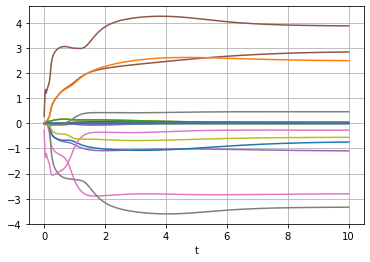

In [26]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [27]:
for i in range(coeff*N):  
    print(Y[-1][i])

0.0015081460080908638
0.0015081460097812183
-0.0017749520710243244
-0.00016526226183821428
-1.094256521840291
3.887188771066505
-2.8063508727278843
-3.339379279278629
2.6419903639028944e-11
-2.911589264012385e-11
-0.7428216491379925
0.04005556329662535
0.040055563297326305
0.04449030222565051
0.005527578751284555
2.8487009156549363
-0.2706078787245409
0.4650856420461261
-0.5552600438823949
0.0009203803045264489
0.0003055247489601598
2.500573796117916


In [28]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [29]:
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi

In [30]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [31]:
psi = var_ansatz(start_point,psi_0)

In [32]:
psi_ground = eigenvec[:,0]


In [41]:
expt_value_u = np.zeros(len(time_domain))
energy = np.zeros(len(time_domain))

psi = var_ansatz(start_point,psi_0)
for tt in range(len(time_domain)):
    theta = []
    for i in range(coeff*N):
        theta.append(Y[tt][i])

    psi_var = var_ansatz(theta,psi_0)
    for i in range(L+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))
    print(norm)

    expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
    energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)


0.9999936781808981
0.9999957674246366
0.99999666964725
0.9999892457234854
0.9999859968934625
0.9999800594117992
0.9999811221752645
0.9999536024548288
0.9999259741869931
0.9998801451554242
0.999838248329804
0.9998063766277842
0.999782562875629
0.9997573574436374
0.9997278923258414
0.9996932440609657
0.9996524516410403
0.9996041438037073
0.9995464179553191
0.9994780080403999
0.9994033667712242
0.9993364990179653
0.9992889616083613
0.9992605359173485
0.999245272164578
0.9992373811683901
0.9992327864065897
0.999228908674246
0.999224173047824
0.9992176237893533
0.9992086766840396
0.9991969694166076
0.9991822728580456
0.9991644385344286
0.9991433673434267
0.9991189907745975
0.9990912595370489
0.9990601366005913
0.9990255928673416
0.9989876043954593
0.998946150515278
0.9989012124346397
0.9988527720953787
0.9988008111563774
0.9987453100624244
0.9986862472232718
0.9986235983769107
0.9985573362436508
0.998487430588516
0.99841384879405
0.9983365570027412
0.9982555218222019
0.9981707125091595
0.99

0.9913444753856152
0.9913567932209126
0.9913689938383177
0.9913810776129568
0.9913930449304773
0.991404896186777
0.9914166317877302
0.9914282521489285
0.9914397576954159
0.9914511488614254
0.9914624260901347
0.9914735898334042
0.9914846405515355
0.9914955787130253
0.9915064047943242
0.9915171192795982
0.9915277226604959
0.9915382154359182
0.9915485981117892
0.9915588712008321
0.9915690352223506
0.9915790907020111
0.9915890381716232
0.9915988781689404
0.9916086112374402
0.9916182379261257
0.9916277587893231
0.9916371743864872
0.9916464852820003
0.9916556920449853
0.9916647952491139
0.9916737954724238
0.9916826932971321
0.9916914893094595
0.9917001840994538
0.9917087782608145
0.9917172723907176
0.9917256670896591
0.9917339629612812
0.9917421606122125
0.9917502606519073
0.9917582636924952
0.9917661703486185
0.9917739812372887
0.9917816969777322
0.9917893181912544
0.9917968455010855
0.9918042795322451
0.9918116209114101
0.9918188702667697
0.9918260282278991
0.9918330954256286
0.99184007249

0.991987354362883
0.9919865164881801
0.9919856815611371
0.9919848495838101
0.991984020558042
0.9919831944854633
0.9919823713675026
0.9919815512053819
0.9919807340001272
0.9919799197525644
0.9919791084633294
0.9919783001328633
0.9919774947614236
0.9919766923490815
0.9919758928957252
0.991975096401069
0.9919743028646438
0.9919735122858153
0.9919727246637734
0.9919719399975432
0.9919711582859844
0.9919703795277938
0.9919696037215108
0.991968830865516
0.9919680609580361
0.9919672939971493
0.9919665299807808
0.9919657689067101
0.9919650107725762
0.9919642555758703
0.9919635033139497
0.9919627539840336
0.9919620075832051
0.9919612641084178
0.9919605235564942
0.9919597859241306
0.9919590512078941
0.9919583194042353
0.9919575905094766
0.9919568645198301
0.9919561414313843
0.991955421240117
0.9919547039418933
0.9919539895324685
0.9919532780074881
0.9919525693624932
0.9919518635929189
0.9919511606941036
0.9919504606612759
0.9919497634895743
0.9919490691740396
0.9919483777096143
0.991947689091154

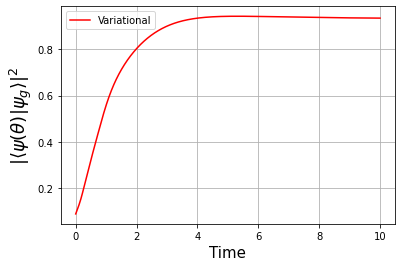

In [42]:
plt.plot(time_domain,expt_value_u, color = "red",label = "Variational")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
#plt.xlim(2.8,3)
#plt.ylim(0.99,1)

#plt.savefig("real_time_evolution\fermion_numbers_1layer.pdf")

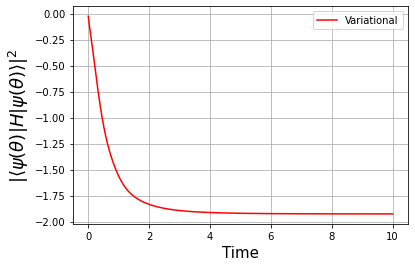

In [43]:
plt.plot(time_domain,energy, color = "red",label = "Variational")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
#plt.xlim(0,10)
#plt.ylim(-1.35,-1.25)

#plt.savefig("real_time_evolution\fermion_numbers_1layer.pdf")

In [44]:
print(expt_value_u[-1])

0.9336591789075024


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
